In [109]:
# machine learning and NLP libraries
import torchtext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report
from gensim.matutils import corpus2dense, corpus2csc
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim import models
# other libraries
import warnings

# own modules
from src.basic_project import preprocessing, extract_data, BasicModel

# ignore warnings
warnings.filterwarnings('ignore')

## Data Extraction and Pre-Processing

In [90]:
texts, labels, costs, contributions = extract_data('data/projects.xlsx', 'data/SciVocCodes.xlsx')
texts = preprocessing(texts)

In [91]:
# get texts in right format
D = Dictionary([sentence.split(' ') for sentence in texts])
n_tokens = len(D)
reviews_bow = [D.doc2bow(doc.split(' ')) for doc in texts]

## Basic Vectorization Techniques

### Tf-Idf

In [6]:
# compute tfidf representations
tfidf = TfidfModel(reviews_bow)
reviews_tfidf = tfidf[reviews_bow]

# create sparse corpus
num_docs = len(reviews_bow)
corpus_tfidf_sparse = corpus2csc(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T

In [ ]:
model = BasicModel(corpus_tfidf_sparse, labels)

In [ ]:
print(f'accuracy: {model.accuracy}')

In [ ]:
print(model.classification_report)

### Embeddings

In [8]:
embeddings = np.zeros((len(texts), 300))
glove = torchtext.vocab.GloVe(name='6B', dim=300)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

In [9]:
model = BasicModel(embeddings, labels)

In [15]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6768857690045743


In [16]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.58      0.82      0.68       488
           1       0.81      0.52      0.63      1326
           2       0.60      0.70      0.64       659
           3       0.25      0.64      0.36        73
           4       0.61      0.59      0.60       549
           5       0.49      0.79      0.60       111

    accuracy                           0.63      3206
   macro avg       0.56      0.68      0.59      3206
weighted avg       0.67      0.63      0.63      3206



## Basic Vectorization Techniques with Additional Features

In [ ]:
costs = normalize(np.expand_dims(costs, 1), axis=1)
contributions = normalize(np.expand_dims(costs, 1))

### Tf-Idf

In [ ]:
dataset = hstack((corpus_tfidf_sparse, csr_matrix(costs), csr_matrix(contributions)))

In [ ]:
model = BasicModel(dataset, labels)

In [ ]:
print(f'accuracy: {model.accuracy}')

In [ ]:
print(model.classification_report)

### Embeddings

In [ ]:
embeddings = np.zeros((len(texts), 300))
glove = torchtext.vocab.GloVe(name='6B', dim=300)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

In [37]:
dataset = np.concatenate((embeddings, costs, contributions), axis=1)

In [42]:
model = BasicModel(dataset, labels)

In [43]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6770114603067362


In [44]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.58      0.82      0.68       488
           1       0.81      0.52      0.63      1326
           2       0.60      0.70      0.64       659
           3       0.25      0.64      0.36        73
           4       0.61      0.59      0.60       549
           5       0.49      0.79      0.60       111

    accuracy                           0.63      3206
   macro avg       0.56      0.68      0.59      3206
weighted avg       0.67      0.63      0.63      3206



### ======== LDA MODEL ========

Since to make use of the LDA model it is necessary to define the number of topics we want in our model, we will make use of the perplexity metric.

Perplexity is a metric used to evaluate the performance of a topic model in natural language processing. It is defined as the inverse of the logarithm of the average probability of the documents in the test set under the model. 

An LDA model with a lower perplexity is considered more accurate and has a better generalization ability.


------

In [127]:
# Function to determine the optimal number of topics in the LDA model --> We calculate it using the perplexity metric.
def ntopics_optim(num_topics,reviews_bow,n_tokens):
    ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)
    return ldag.log_perplexity(reviews_bow)


In [128]:
def plot_perplexity(nt,perplexity):
    plt.plot(nt, perplexity, marker='o', linestyle='--', color='r', label='Perplexity') 
    plt.title("Perplexity plot to determine the number of topics")
    plt.ylabel('perplexity value')
    plt.xlabel('num of topics') 
    plt.show()

##### Study for perplexity metric

In [106]:
nt = [40,50,60,65,70,80,90,95,100,200] 
perplexity = []
for i in range(len(nt)):
    p = ntopics_optim(nt[i],reviews_bow,n_tokens)
    perplexity.append(p)


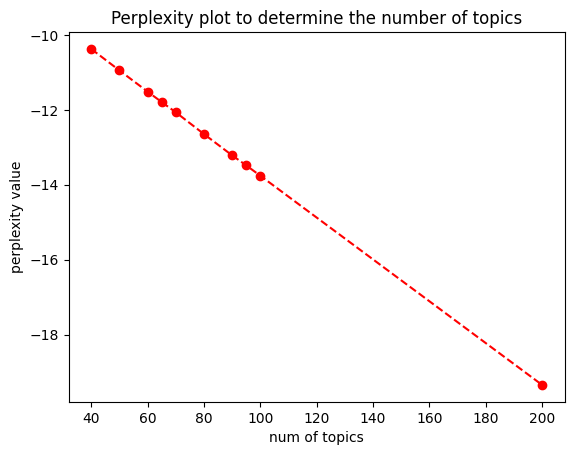

In [114]:
plot_perplexity(nt,perplexity)

We note that the optimum value for topics is 200 because his value are the smallest

==== Compute LDA model ====

In [116]:
def lda_model(reviews_bow,num_topics):
    # compute LDA model
    ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)
    # create sparse corpus
    corpus_ldag = ldag[reviews_bow]
    num_docs = len(reviews_bow)
    return corpus2csc(corpus_ldag, num_terms=n_tokens, num_docs=num_docs).T


In [117]:
corpus_ldag_sparse = lda_model(reviews_bow, 200)
model = BasicModel(corpus_ldag_sparse, labels)

In [118]:
print(f'accuracy: {model.accuracy*100:.2f}%')

accuracy: 59.87%


In [119]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.57      0.77      0.65       488
           1       0.74      0.58      0.65      1326
           2       0.59      0.66      0.62       659
           3       0.30      0.29      0.29        73
           4       0.57      0.59      0.58       549
           5       0.60      0.70      0.65       111

    accuracy                           0.63      3206
   macro avg       0.56      0.60      0.57      3206
weighted avg       0.64      0.63      0.63      3206



##### New study for perplexity metric

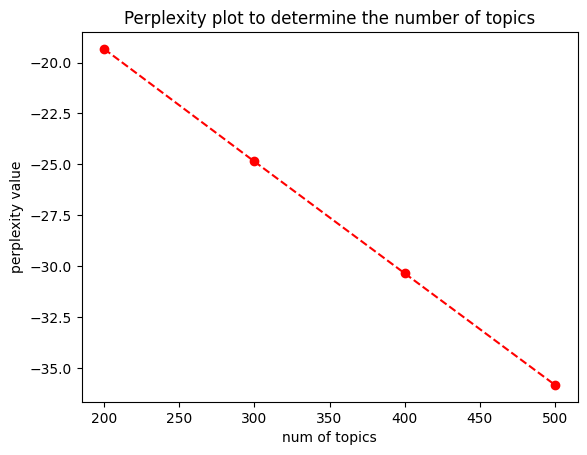

In [129]:
nt = [200,300,400,500] 
perplexity = []
for i in range(len(nt)):
    p = ntopics_optim(nt[i],reviews_bow, n_tokens)
    perplexity.append(p)

plot_perplexity(nt,perplexity)


In [132]:
perplexity

[-19.33183056075147,
 -24.857255148912824,
 -30.34615511758675,
 -35.82346883337626]

In [130]:
corpus_ldag_sparse = lda_model(reviews_bow, 500)
model = BasicModel(corpus_ldag_sparse, labels)
print(f'accuracy: {model.accuracy*100:.2f}%')

accuracy: 58.28%


In [131]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.63      0.74      0.68       488
           1       0.72      0.66      0.69      1326
           2       0.58      0.64      0.61       659
           3       0.37      0.27      0.31        73
           4       0.60      0.57      0.58       549
           5       0.60      0.61      0.60       111

    accuracy                           0.64      3206
   macro avg       0.58      0.58      0.58      3206
weighted avg       0.65      0.64      0.64      3206

